# Caso práctico: Determinación de patrones de tráfico

En este caso práctico se analizarán datos de tráfico recogidos con el sistema PeMS (California Freeway Performance Measurement System). Este sistema cuenta con $25000$ sensores individuales. En este estudio se consideran exclusivamente dos sensores y $100$ días del año $2013$. El objetivo es establecer los patrones de tráfico presentes en la zona de estudio.



## Datos usados para este problema

Los tres parámetros esenciales que caracterizan el tráfico son: **flujo**, **densidad** y **velocidad**. El flujo es el número de vehículos que pasan por un punto de la vía por unidad de tiempo, se mide en  vehículos/hora. La densidad se mide en número de vehículos por unidad de longitud, por ejemplo número de vehículos por kilómetro. Finalmente con respecto a la velocidad, como los datos corresponden a una zona en Estados Unidos, la unidad de longitud es la milla (mi), midiéndose la velocidad en millas por hora. En lugar de la densidad los sensores registran la ocupación de la vía, es decir, la proporción de la vía ocupada por vehículos, la cual se registra en tantos por uno. Los sensores realizan un registro cada $5$ minutos. Por lo tanto, se tienen $288$ instantes al día.

Hemos simplificado este problema, considerado solamente las observaciones de velocidad. Estos datos se han preprocesado en una matriz $X$, la cual contiene los datos necesarios para realizar el análisis cluster. Las filas están asociadas a los días y las columnas a todas las mediciones realizadas en un día (en cada instante de tiempo) por ambos sensores, primero los $288$ instantes del primer sensor y después los $288$ instantes del segundo sensor. Por lo tanto, la matriz resultante $X$ tiene $100$ filas (días) y $288$ instantes $\times$ $2$ sensores $=576$ columnas.

Los datos descritos en este problema se encuentran disponibles en los siguientes enlaces:
* Flujos: https://drive.google.com/file/d/1zqCAjWa1cYgfOAcEIX92AeRN3CypVvp1
* Ocupación: https://drive.google.com/file/d/1MU35K_6254fATgsEhlbRkI29qtlJIJK7
* Velocidad: https://drive.google.com/file/d/1v5yoaUtR5BjG1nj9koBkyLwqOiyBLSXA

Como se ha mencionado, en el problema utilizaremos únicamente los datos de **velocidad**. Procedemos a su descargar y la importación de estos en Python.

In [ ]:
import numpy as np

# Descargar el dataset que se utilizará utiliznado un enlace compartido de google drive
# Si la URL es https://drive.google.com/file/d/IDFICHEROCOMPARTIDO se debe utilizar:
# !gdown --id IDFICHEROCOMPARTIDO 
!gdown --id 1v5yoaUtR5BjG1nj9koBkyLwqOiyBLSXA

# El fichero puede descargarse manualmente en https://drive.google.com/file/d/1v5yoaUtR5BjG1nj9koBkyLwqOiyBLSXA

# Cargamos el fichero
X = np.genfromtxt('patronesTrafico_velocidad.csv', delimiter=',')
# Mostrar filas y columnas de la matriz de datos
X.shape

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1v5yoaUtR5BjG1nj9koBkyLwqOiyBLSXA
To: /content/patronesTrafico_velocidad.csv
100% 276k/276k [00:00<00:00, 77.3MB/s]


(100, 576)

## Detección del número de clusters

Por tratarse de un caso real el número de clusters $K$ es desconocido. Vamos a aplicar  el criterio basado en el BIC para el cálculo de este hiperparámetro, para ello haremos uso de la función *BIC* (previamente empleada en el Ejemplo 6.1).  

Tras ejecutar el siguiente código podemos observar que el BIC decrece hasta $K=3$ y luego crece de nuevo. Por lo tanto $K=3$ será el valor elegido.

In [ ]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

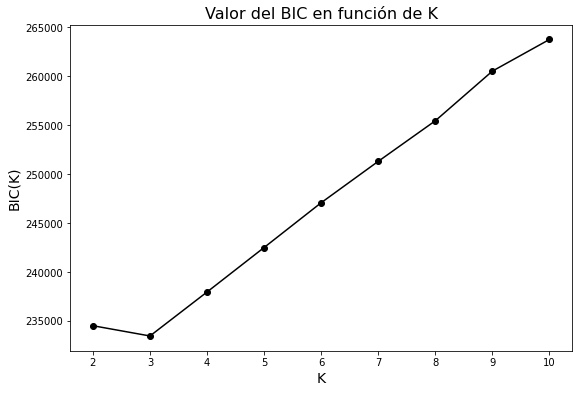

In [ ]:
## Calculo del BIC
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Kmax = 10
BIC_array = []
for k in range(2, Kmax+1):
  kmeans = KMeans(n_clusters=k, n_init=15, random_state=100)
  grupos = kmeans.fit_predict(X)
  BIC_array.append(BIC(k, grupos, X))

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(9, 6))
plt.plot(np.arange(2, Kmax+1), BIC_array, "ko-")
plt.title("Valor del BIC en función de K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.show()

## Detección de outliers (anomalías)

Vamos a aplicar el método de Jackknife para detectar las observaciones influyentes.  El siguiente código detecta los outliers y los elimina del análisis y los representa visualmente. Notar que si el número de réplicas en el número de veces que se realiza el algoritmo de las k-medias es pequeño el procedimiento detecta diferentes conjunto de outliers ya que llega a diferentes soluciones. Hemos fijado este valor a $30$.

In [ ]:
## Detección de outliers
N = X.shape[0] # Número de observaciones
K = 3 # Número de clusters

SSE = []
for i in range(0, N):
  X_sin_i = np.delete(X, i, axis=0) # Eliminamos la observación i
  # Aplicamos K-medias a X_sin_i y obtenemos el índice SSE
  kmeans = KMeans(n_clusters=K, n_init=30, random_state=100).fit(X_sin_i)
  SSE.append(kmeans.inertia_)

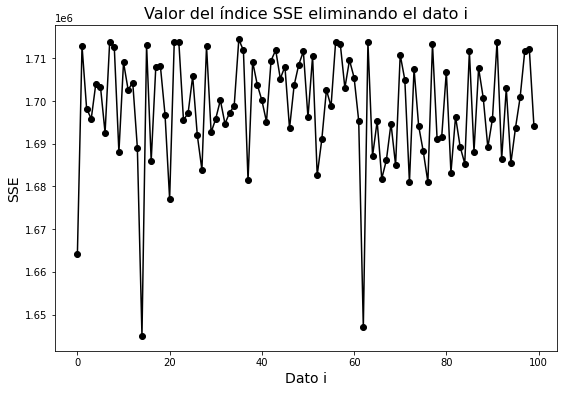

In [ ]:
## Detección visual de outliers
# Dibujamos el SSE obtenido eliminando cada observación
plt.figure(figsize=(9, 6))
plt.plot(np.arange(0, N), SSE, "ko-")
plt.title("Valor del índice SSE eliminando el dato i", fontsize=16)
plt.xlabel("Dato i", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.show()

In [ ]:
## Detección analítica de outliers
sigma = np.std(SSE) # Desviación típica de SSE
mu = np.mean(SSE) # Media
umbral = 2 # Umbral: 2 para distribuciones normales y 3 para cualquier otra distribución

outliers = []
for i in range(0, N):
  if np.abs(SSE[i]-mu) > umbral*sigma:
    outliers.append(i)
print(outliers)

[0, 14, 62]


En este caso detectamos $3$ observaciones influyentes (tanto mediante la detección visual como con la detección analítica). Cuando detectemos los patrones podemos volver a analizar los outliers para ver que información nos están proporcionando.

A continuación vamos a representar visualmente estos outliers y los eliminaremos de nuestro conjunto de datos.

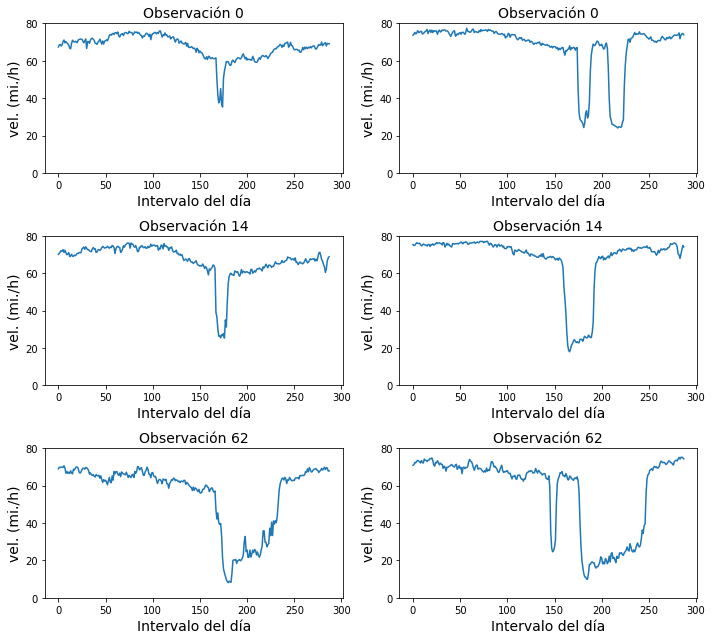

In [ ]:
## Representación y eliminación de outliers
fig, axs = plt.subplots(len(outliers), 2)
fig.set_size_inches(10, 9)
axs = axs.ravel()
for i in range(len(outliers)):
  for j in range(2): # Para cada uno de los dos sensores
    ini_seg_sensor = X.shape[1]//2
    axs[i*2 + j].set_ylim([0, 80]) # Establecer limites del eje y
    axs[i*2 + j].plot(np.arange(0, ini_seg_sensor), X[outliers[i], j*ini_seg_sensor:(j+1)*ini_seg_sensor])
    axs[i*2 + j].set_title("Observación {}".format(outliers[i]), fontsize=14)
    axs[i*2 + j].set_xlabel("Intervalo del día", fontsize=14)
    axs[i*2 + j].set_ylabel("vel. (mi./h)", fontsize=14)

plt.tight_layout()

In [ ]:
## Eliminación de los outliers
X_new = np.delete(X, outliers, axis=0)
X_new.shape

(97, 576)

## Determinación de patrones y estudio

Finalmente calculamos los patrones mediante el algoritmo $K-$means, los repesentamos gráficamente y calculamos el los intervalos de congestión en cada patrón. Fijamos como existencia de congestión que la velocidad se reduzca por debajo de los $50$ millas a la hora. 

In [ ]:
## Cálculo de patrones
kmeans = KMeans(n_clusters=K, n_init=30, random_state=100)
pred = kmeans.fit_predict(X_new)
centroides = kmeans.cluster_centers_

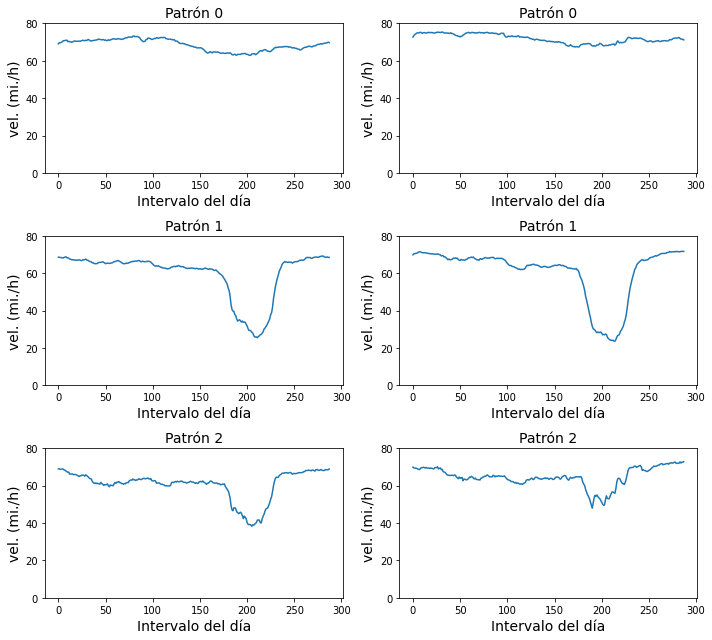

In [ ]:
## Representación gráfica de los patrones encontrados
fig, axs = plt.subplots(len(outliers), 2)
fig.set_size_inches(10, 9)
axs = axs.ravel()
for i in range(K):
  for j in range(2): # Para cada uno de los dos sensores
    ini_seg_sensor = X_new.shape[1]//2
    axs[i*2 + j].set_ylim([0, 80]) # Establecer limites del eje y
    axs[i*2 + j].plot(np.arange(0, ini_seg_sensor), centroides[i, j*ini_seg_sensor:(j+1)*ini_seg_sensor])
    axs[i*2 + j].set_title("Patrón {}".format(i), fontsize=14)
    axs[i*2 + j].set_xlabel("Intervalo del día", fontsize=14)
    axs[i*2 + j].set_ylabel("vel. (mi./h)", fontsize=14)

plt.tight_layout()

La gráfica obtenida muestra tres patrones. El **Patrón 2** es una situación de tráfico sin congestión, el **Patrón 1** es el más congestionado y el **Patrón 0** es una congestión moderada. 

A continuación vamos a generar una tabla donde se puedan ver datos sobre cada uno de los patrones que hemos encontrado. En concreto, vamos a obtener:
*   Número de días que se ha repetido este patrón.
*   Velocidad media en los periodos de congestión (si existe). Se considera un periodo de congestión aquél con una velocidad menor a 50 millas/hora.
*   Momento de inicio y de fin del periodo de congestión (si existe).

In [ ]:
import pandas as pd

## Determinación de los periodos de congestión ocasionados en cada grupo (cluster)
congestion = 50
N_dias_patron = np.bincount(pred) # Contar el número de días que se ha repetido cada patrón
tabla = pd.DataFrame(columns=["Patrón", "N. días", "Sensor 1 - Vel. media", "Sensor 1 - Ini", "Sensor 1 - Fin",
                              "Sensor 2 - Vel. media", "Sensor 2 - Ini", "Sensor 2 - Fin"])

for k in range(K):
  tabla.loc[k, "Patrón"] = k
  tabla.loc[k, "N. días"] = N_dias_patron[k]
  for sensor in range(2):
    ini_seg_sensor = X_new.shape[1]//2
    indices = np.argwhere(centroides[k, sensor*ini_seg_sensor:(sensor+1)*ini_seg_sensor] < congestion)
    if len(indices) > 0: # Se ha producido congestión (periodos a velocidad < congestion)
      tabla.loc[k, "Sensor {:d} - Vel. media".format(sensor+1)] = np.mean(centroides[k, indices])
      tabla.loc[k, "Sensor {:d} - Ini".format(sensor+1)] = indices[0,0] * 5/60
      tabla.loc[k, "Sensor {:d} - Fin".format(sensor+1)] = indices[-1,0] * 5/60
    else: # No hay congestión de tráfico
      tabla.loc[k, "Sensor {:d} - Vel. media".format(sensor+1)] = "> 50"
      tabla.loc[k, "Sensor {:d} - Ini".format(sensor+1)] = 0
      tabla.loc[k, "Sensor {:d} - Fin".format(sensor+1)] = 0

# Mostrar la tabla
display(tabla)

,Patrón,N. días,Sensor 1 - Vel. media,Sensor 1 - Ini,Sensor 1 - Fin,Sensor 2 - Vel. media,Sensor 2 - Ini,Sensor 2 - Fin
0,0,28,> 50,0,0,> 50,0,0
1,1,49,33.44983,15.166667,19.083333,33.147373,15.25,19.083333
2,2,20,43.484634,15.25,18.583333,42.495,15.75,16.916667


En la tabla anterior (dataframe *tabla*) se calcula el número de días que se ha repetido cada patrón. Notar que los sensores recolectan datos de $100$ días. Dado que una semana tiene $7$ días, tenemos datos de $14$ semanas. Estas cantidades pueden indicar que el **Patrón 2** corresponde a sábados y domingos, ya que corresponde con $14$ semanas $\times$ $2$ días por semana e indica que no hay congestión; el **Patrón 1** puede indicar días laborables entre semana; finalmente el **Patrón 0** puede indicar viernes y otros días laborales con menos afluencia de tráfico. 

Además, se ha calculado los intervalos de congestión definidos como los instantes de tiempo que la velocidad desciende de las $50$ millas/hora.  Se observa que este efecto de la congestión aparece cuando la gente vuelve del trabajo. Se ha medido la velocidad media en dichos intervalos observando que el patrón **Patrón 2** no aparece la congestión y en los otros dos está presente con diferente intensidad.